In [1]:
import csv
import cv2
import numpy as np

csv_file = 'data/driving_log.csv'

In [2]:
def load_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

car_images = []
steering_angles = []

with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            steering_center = float(row[3])

            # create adjusted steering measurements for the side camera images
            correction = 0.2 # this is a parameter to tune
            steering_left = steering_center + correction
            steering_right = steering_center - correction

            # read in images from center, left and right cameras
            path = 'data/IMG/' # fill in the path to your training IMG directory
            img_center = load_image(path + row[0].split('/')[-1])
            img_left = load_image(path + row[1].split('/')[-1])
            img_right = load_image(path + row[2].split('/')[-1])

            # add images and angles to data set
            car_images.extend([img_center, img_left, img_right])
            steering_angles.extend([steering_center, steering_left, steering_right])

# Data aAugmentation

augmented_images = []
augmented_measurements = []
for image, measurement in zip(car_images,steering_angles):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augmented_measurements.append(measurement * -1.0)

X_train = np.asarray(augmented_images)
y_train = np.asarray(augmented_measurements)

In [8]:
### Load dataset using a generator

samples = []
with open(csv_file) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def load_image(path):
    image = cv2.imread(path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        np.random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []
            steering_angles = []
            for batch_sample in batch_samples:

                steering_center = float(batch_sample[3])

                # create adjusted steering measurements for the side camera images
                correction = 0.2 # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction

                # read in images from center, left and right cameras
                path = 'data/IMG/' # fill in the path to your training IMG directory
                img_center = load_image(path + batch_sample[0].split('/')[-1])
                img_left = load_image(path + batch_sample[1].split('/')[-1])
                img_right = load_image(path + batch_sample[2].split('/')[-1])

                # add images and angles to data set
                car_images.extend([img_center, img_left, img_right])
                steering_angles.extend([steering_center, steering_left, steering_right])
            
            augmented_images = []
            augmented_measurements = []
            for image, measurement in zip(car_images,steering_angles):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image, 1))
                augmented_measurements.append(measurement * -1.0)

            X_train = np.asarray(augmented_images)
            y_train = np.asarray(augmented_measurements)
                
            yield sklearn.utils.shuffle(X_train, y_train)


In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Lambda, Cropping2D
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

Using TensorFlow backend.


In [4]:
### Simple neural network implementation
def SimpleNN():

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5,input_shape=(160, 320, 3)))
    model.add(Flatten())
    model.add(Dense(20))
    model.add(Dense(20))
    model.add(Dense(1))
    return model
    
### LeNet ConvNet implementation
def LeNet():

    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5,input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    model.add(Convolution2D(6, 5, 5, activation="relu"))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, 5, activation="relu"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84)) 
    model.add(Dense(1))

    return model

### Nvidia Architecture implementation
def NvidiaNet():
    
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5,input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation="relu"))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation="relu"))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))
    model.add(Convolution2D(64, 3, 3, activation="relu"))
    model.add(Convolution2D(64, 3, 3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    
    return model



In [5]:
### Choose model
#model = SimpleNN()
model = LeNet()
#model = NvidiaNEt()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`


In [9]:
# compile and train the model using the generator function
batch_size=32
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

### Train and save using a generator

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator,
                                     steps_per_epoch=np.ceil(len(train_samples)/batch_size),
                                     validation_data=validation_generator,
                                     nb_val_samples=len(validation_samples),
                                     nb_epoch=3)

model.save('model.h5')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=40.0, validation_data=<generator..., epochs=3, validation_steps=313)`
  


Epoch 1/3
39/40 [============================>.] - ETA: 1s - loss: 0.0386

KeyboardInterrupt: 

In [10]:
### Train and save

model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2)

model.save('model.h5')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 7512 samples, validate on 1878 samples
Epoch 1/2
7512/7512 [==============================] - 85s - loss: 0.0359 - val_loss: 0.0285
Epoch 2/2
7512/7512 [==============================] - 85s - loss: 0.0291 - val_loss: 0.0324


dict_keys(['val_loss', 'loss'])


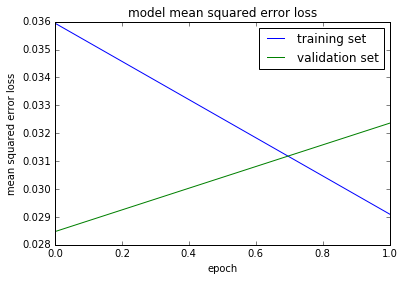

In [11]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()